<h1 style="color:blue; font-size:50px; font-family:Arial">Classification Models</h1>

Une fois que les caractéristiques des données ont été extraites, nous entrons dans le cadre d'un modèle de classification supervisée classique. Dans notre cas, il n'y a pas de problème de déséquilibre de données, étant donné que nous avons déjà basé notre exemple sur 500 liens de phishing et 500 liens légitimes. 

In [84]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt

In [80]:
#Cette ligne de code utilise le module warnings de Python pour ignorer les avertissements de catégorie DeprecationWarning
import warnings
warnings.filterwarnings('ignore')

In [11]:
df=pd.read_csv('urldata.csv')

df.head()

,Nom_de_Domaine,have_IP,have_at,longueur,profondeur,nb_de_caractere_spec,redirection,http_ds_domaine,red_URL,whois,periode_de_vie,age_url,iframe,forwarding,label
0,blogger,0,0,0,0,1,0,0,0,0,0,0,0,4,0
1,google,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,youtube,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,linkedin,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,google,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [28]:
df.dtypes

Nom_de_Domaine          object
have_IP                  int64
have_at                  int64
longueur                 int64
profondeur               int64
nb_de_caractere_spec     int64
redirection              int64
http_ds_domaine          int64
red_URL                  int64
whois                    int64
periode_de_vie           int64
age_url                  int64
iframe                   int64
forwarding               int64
label                    int64
dtype: object

## Modèlisation:

Dans la partie de modélisation, nous avons décidé d'utiliser des modèles que nous avons vus dans le cours de Data Science 1 ainsi que dans l'apprentissage machine. Nous avons commencé par une régression logistique, qui a été entraînée sur l'ensemble du dataframe car ce modèle est connu pour bien fonctionner pour les prédictions, donc il n'était pas nécessaire de diviser les données en ensemble de test et d'entraînement. Cependant, pour les deux autres modèles, KNN et Random Forest, nous avons divisé les données en ensembles de test et d'entraînement. Nous avons également optimisé les hyperparamètres de chaque modèle à l'aide de la méthode Grid Search, que nous avons vu en classe.

### Le choix de l'auc comme mesure d'évaluation pours les modèles:

Le AUC (Area Under the Receiver Operating Characteristic Curve) est l'une des meilleures mesures d'évaluation pour un projet de détection de phishing, car il mesure la performance globale du modèle en termes de taux de faux positifs et de taux de vrais positifs.

Dans la détection de phishing, il est important de minimiser les faux positifs, car cela signifie qu'un utilisateur légitime pourrait être bloqué ou empêché d'accéder à un site légitime. En même temps, il est également important de maximiser les vrais positifs, c'est-à-dire détecter autant de sites de phishing que possible.

Le AUC permet d'évaluer la capacité du modèle à discriminer entre les sites de phishing et les sites légitimes en évaluant la courbe ROC (Receiver Operating Characteristic) qui représente la relation entre les taux de faux positifs et les taux de vrais positifs à différents seuils de classification. Plus la courbe ROC est proche du coin supérieur gauche du graphique, plus le modèle est performant. Le AUC mesure donc la performance globale du modèle, quelle que soit la valeur seuil choisie pour la classification.

### Modèle 1: Régression Logistique 

In [53]:
# Importer GridSearchCV
from sklearn.model_selection import GridSearchCV

# Définir la grille d'hyperparamètres à tester
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'penalty': ['l1', 'l2']}

# Instancier l'objet GridSearchCV
grid_search = GridSearchCV(logit_reg, param_grid, cv=5, scoring='roc_auc')

# Exécuter la recherche sur grille
grid_search.fit(X, y)

# Afficher les meilleurs hyperparamètres et le score correspondant
print("Meilleurs hyperparamètres:", grid_search.best_params_)

# Utiliser les meilleurs hyperparamètres pour entraîner le modèle final
logit_reg = LogisticRegression(penalty=grid_search.best_params_['penalty'], 
                               C=grid_search.best_params_['C'], 
                               solver='liblinear')
logit_reg.fit(X, y)

Meilleurs hyperparamètres: {'C': 100, 'penalty': 'l1'}


LogisticRegression(C=100, penalty='l1', solver='liblinear')

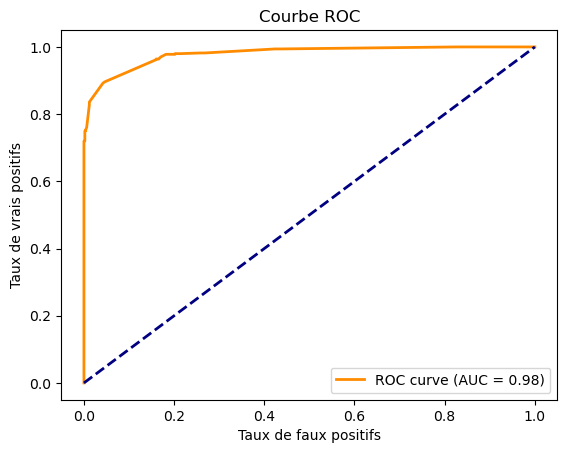

In [54]:
# Calculer les probabilités de prédiction pour chaque classe
y_scores = logit_reg.predict_proba(X)[:, 1]

# Calculer le taux de faux positifs, le taux de vrais positifs et les seuils pour la courbe ROC
fpr, tpr, thresholds = roc_curve(y, y_scores)

# Calculer l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

### Modèle 2: KNN

In [48]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instancier le modèle de k-NN
knn = KNeighborsClassifier()

# Définir les hyperparamètres à optimiser
hyperparameters = {'n_neighbors': [3, 5, 7, 9, 11],
                   'weights': ['uniform', 'distance'],
                   'algorithm': ['ball_tree', 'kd_tree', 'brute']}

# Instancier l'objet GridSearchCV
grid_search = GridSearchCV(knn, hyperparameters, cv=5, scoring='roc_auc')

# Exécuter la recherche sur grille
grid_search.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres et le score ROC AUC correspondant
print("Meilleurs hyperparamètres:", grid_search.best_params_)

# Utiliser les meilleurs hyperparamètres pour entraîner le modèle final
best_knn = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'], 
                                 weights=grid_search.best_params_['weights'], 
                                 algorithm=grid_search.best_params_['algorithm'])
best_knn.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test et évaluer la performance
y_pred = best_knn.predict(X_test)

Meilleurs hyperparamètres: {'algorithm': 'brute', 'n_neighbors': 11, 'weights': 'distance'}


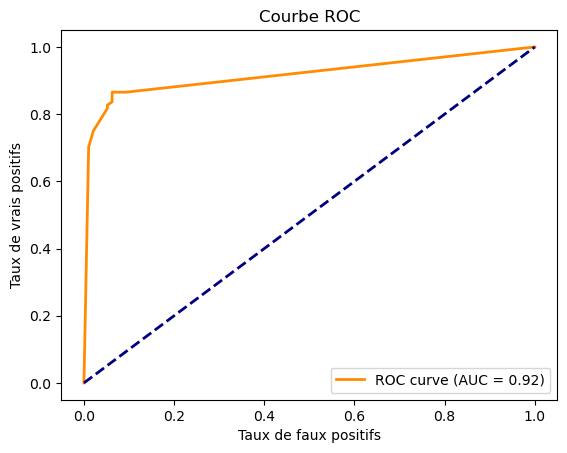

In [49]:
# Calculer les probabilités de prédiction pour chaque classe
y_scores = best_knn.predict_proba(X_test)[:, 1]

# Calculer le taux de faux positifs, le taux de vrais positifs et les seuils pour la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calculer l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

### Modèle 3: Random Forest

In [57]:
# Instancier le modèle de Random Forest
rf = RandomForestClassifier(random_state=42)

# Définir les hyperparamètres à optimiser
hyperparameters = {'n_estimators': [100, 200, 300],
                   'max_depth': [3, 5, 7, 9, None],
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 2, 4],
                   'max_features': ['sqrt', 'log2', None]}

# Instancier l'objet GridSearchCV
grid_search = GridSearchCV(rf, hyperparameters, cv=5, scoring='roc_auc', n_jobs=-1)

# Exécuter la recherche sur grille
grid_search.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres et le score ROC AUC correspondant
print("Meilleurs hyperparamètres:", grid_search.best_params_)

# Utiliser les meilleurs hyperparamètres pour entraîner le modèle final
best_rf = RandomForestClassifier(n_estimators=grid_search.best_params_['n_estimators'], 
                                  max_depth=grid_search.best_params_['max_depth'], 
                                  min_samples_split=grid_search.best_params_['min_samples_split'], 
                                  min_samples_leaf=grid_search.best_params_['min_samples_leaf'], 
                                  max_features=grid_search.best_params_['max_features'], 
                                  random_state=42)
best_rf.fit(X_train, y_train)

Meilleurs hyperparamètres: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


RandomForestClassifier(max_depth=7, max_features='sqrt', min_samples_split=5,
                       n_estimators=300, random_state=42)

In [ ]:
#RandomForestClassifier(max_depth=7, max_features='sqrt', min_samples_split=5, n_estimators=300, random_state=42)

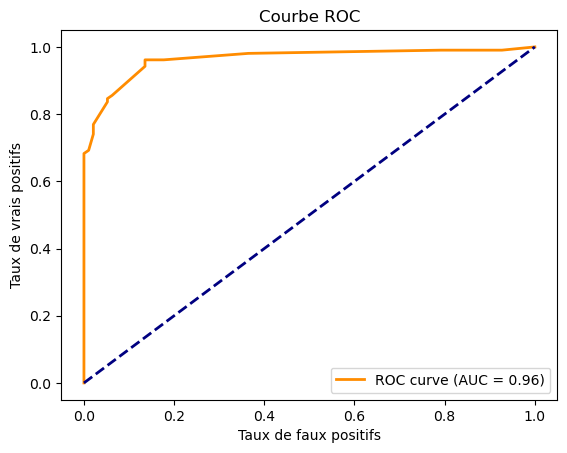

In [58]:
# Calculer les probabilités de prédiction pour chaque classe
y_scores = best_rf.predict_proba(X_test)[:, 1]

# Calculer le taux de faux positifs, le taux de vrais positifs et les seuils pour la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calculer l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

Après avoir analysé les performances des trois modèles de détection de phishing que nous avons construits, il a été constaté que le modèle de régression logistique était le plus performant. Ce modèle a obtenu un score AUC de 0,98, ce qui signifie qu'il est capable de distinguer efficacement les liens de phishing des liens légitimes.

En utilisant ce modèle, nous avons désormais un outil qui peut aider à prédire si un lien est un lien de phishing ou non. Cette capacité est importante pour la sécurité des utilisateurs d'Internet, car elle peut aider à éviter que les utilisateurs ne soient piégés par des escroqueries de phishing et à protéger leurs informations personnelles et financières.

Dans l'ensemble, ces résultats montrent que les modèles de détection de phishing basés sur l'apprentissage automatique peuvent être efficaces dans la détection des liens de phishing. Bien que les modèles de KNN et de forêt aléatoire aient également bien performé, le modèle de régression logistique est le choix optimal pour ce projet de détection de phishing.

# Feature importance

Dans le cadre de notre projet de détection de phishing, il est important de comprendre l'importance des différentes caractéristiques (features) qui sont utilisées pour former nos modèles. Cela peut aider à améliorer la précision des modèles et faciliter leur interprétation. Cependant, étant donné que notre ensemble de données d'origine est relativement limité en termes de taille, nous avons décidé d'utiliser un autre ensemble de données similaire à notre ensemble de données d'origine, mais avec un plus grand nombre d'observations.

Nous allons d'abord entraîner une régression logistique sur ce nouvel ensemble de données, puis étudier l'importance des caractéristiques. Cela nous permettra de mieux comprendre les caractéristiques les plus importantes qui contribuent à la détection de phishing.

In [67]:
df_full=pd.read_csv('full_url_data.csv')
df_full.head()

,Domain,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,https_Domain,TinyURL,Prefix/Suffix,DNS_Record,Web_Traffic,Domain_Age,Domain_End,iFrame,Mouse_Over,Right_Click,Web_Forwards,phishing
0,graphicriver.net,0,0,1,1,0,0,0,0,0,1,1,1,0,0,1,0,0
1,ecnavi.jp,0,0,1,1,1,0,0,0,0,1,1,1,0,0,1,0,0
2,hubpages.com,0,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0
3,extratorrent.cc,0,0,1,3,0,0,0,0,0,1,0,1,0,0,1,0,0
4,icicibank.com,0,0,1,3,0,0,0,0,0,1,0,1,0,0,1,0,0


In [68]:
df_full.dtypes

Domain           object
Have_IP           int64
Have_At           int64
URL_Length        int64
URL_Depth         int64
Redirection       int64
https_Domain      int64
TinyURL           int64
Prefix/Suffix     int64
DNS_Record        int64
Web_Traffic       int64
Domain_Age        int64
Domain_End        int64
iFrame            int64
Mouse_Over        int64
Right_Click       int64
Web_Forwards      int64
phishing          int64
dtype: object

In [69]:
df_full.isna().sum()

Domain           0
Have_IP          0
Have_At          0
URL_Length       0
URL_Depth        0
Redirection      0
https_Domain     0
TinyURL          0
Prefix/Suffix    0
DNS_Record       0
Web_Traffic      0
Domain_Age       0
Domain_End       0
iFrame           0
Mouse_Over       0
Right_Click      0
Web_Forwards     0
phishing         0
dtype: int64

In [72]:
# Voire si on a un problème de désiquilibre des données
df_full['phishing'].value_counts()

0    5000
1    5000
Name: phishing, dtype: int64

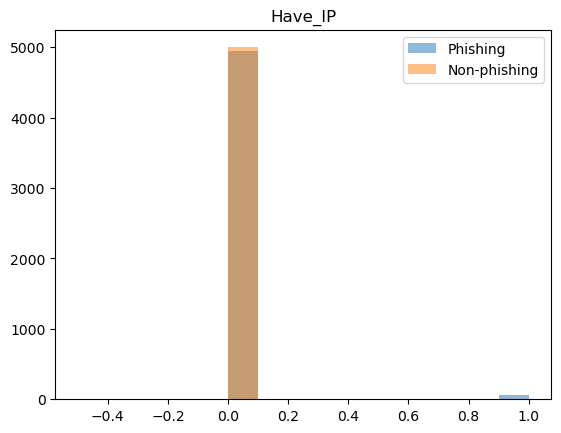

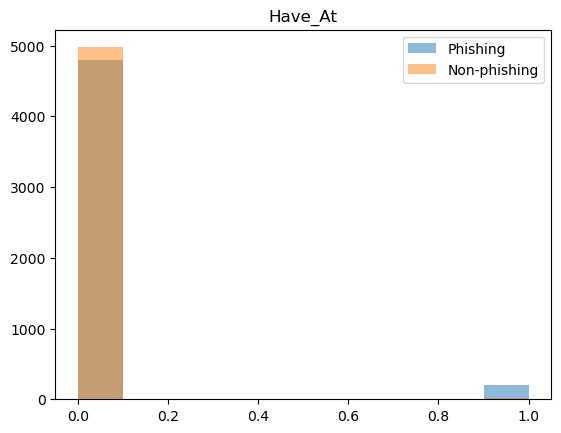

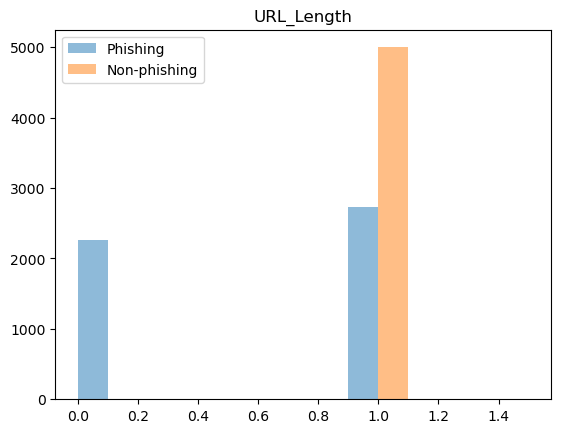

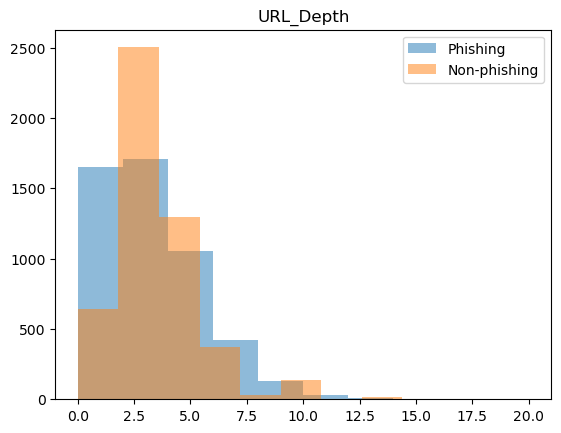

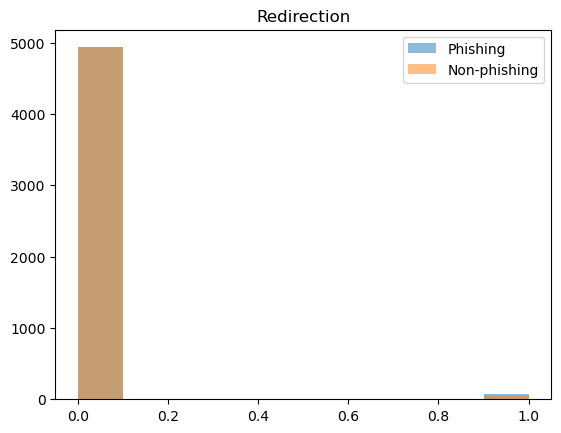

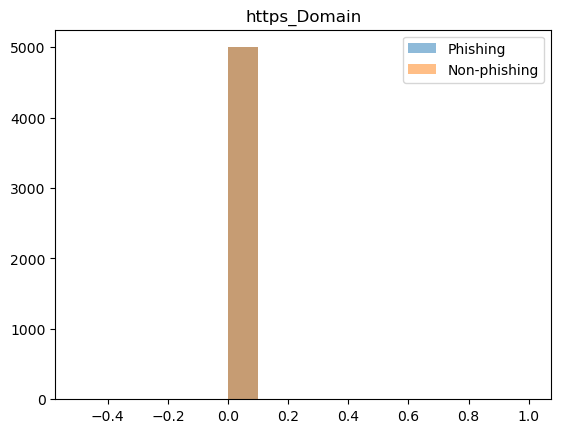

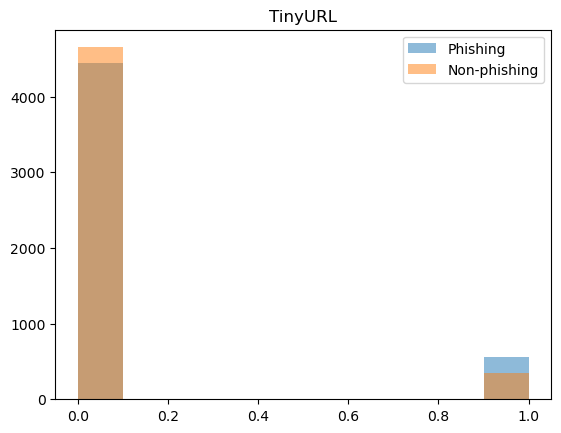

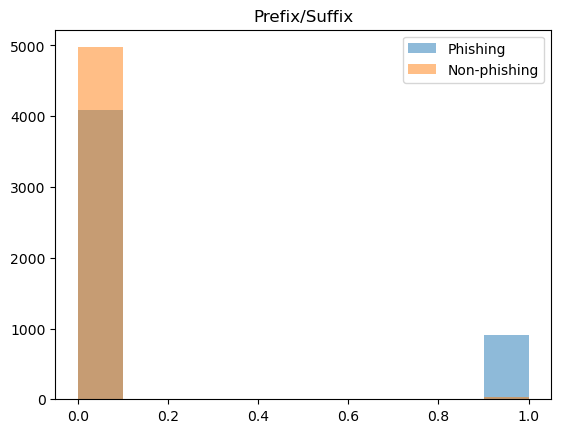

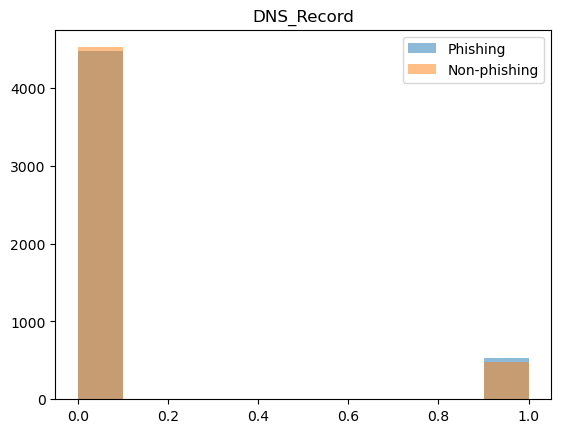

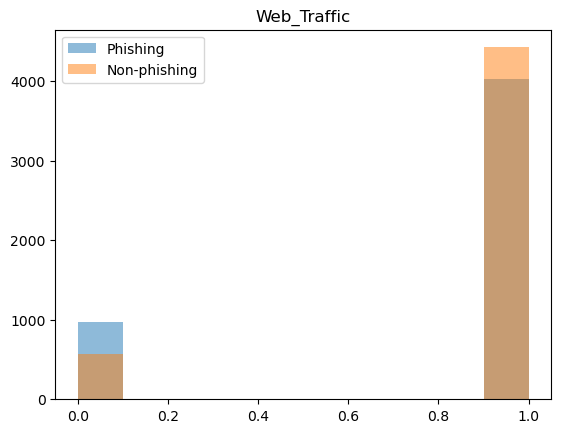

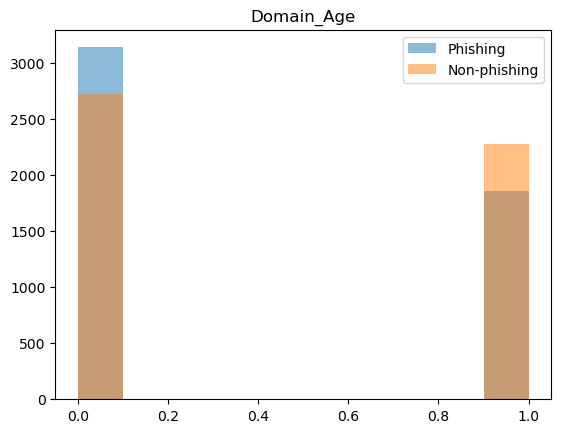

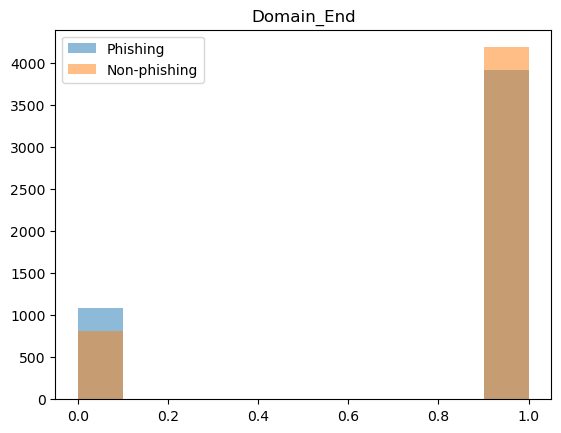

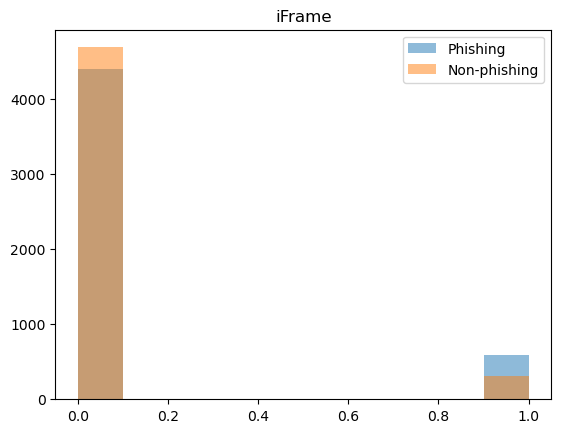

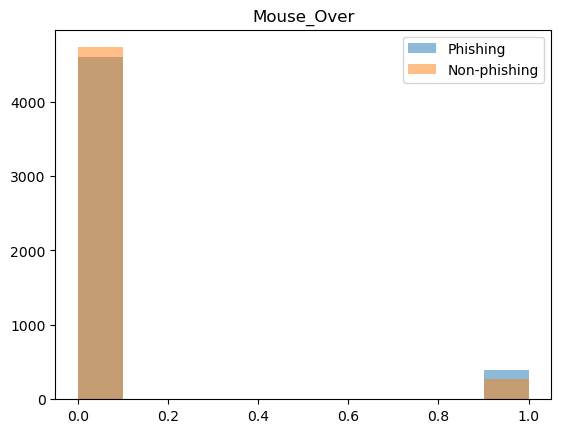

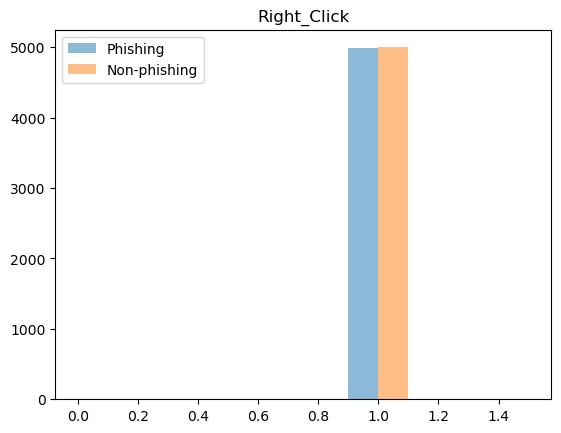

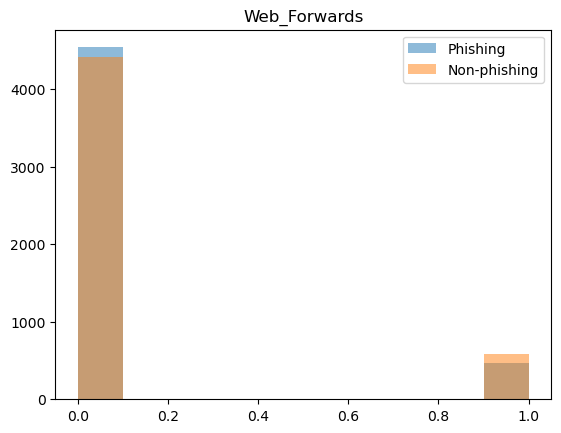

In [74]:
import matplotlib.pyplot as plt

# Sélectionner les caractéristiques numériques et la variable cible
num_features = ['Have_IP', 'Have_At', 'URL_Length', 'URL_Depth', 'Redirection', 'https_Domain', 'TinyURL', 'Prefix/Suffix', 'DNS_Record', 'Web_Traffic', 'Domain_Age', 'Domain_End', 'iFrame', 'Mouse_Over', 'Right_Click', 'Web_Forwards']
target = 'phishing'

# Séparer les liens de phishing des liens non-phishing
phishing_links = df_full[df_full[target] == 1]
non_phishing_links = df_full[df_full[target] == 0]

# Tracer les histogrammes pour chaque caractéristique numérique
for feature in num_features:
    plt.hist(phishing_links[feature], alpha=0.5, label='Phishing')
    plt.hist(non_phishing_links[feature], alpha=0.5, label='Non-phishing')
    plt.title(feature)
    plt.legend()
    plt.show()

Après avoir tracé les histogrammes de chaque feature pour les cas phishing et non-phishing, nous avons observé que les features suivantes différaient considérablement entre les deux groupes:

- Have_At
- URL_Length
- URL_Depth
- Prefix/Suffix
- Right_Click

Cela suggère que ces caractéristiques sont des indicateurs importants pour la détection des attaques de phishing et qu'elles peuvent être utilisées pour former des modèles de détection de phishing plus précis.

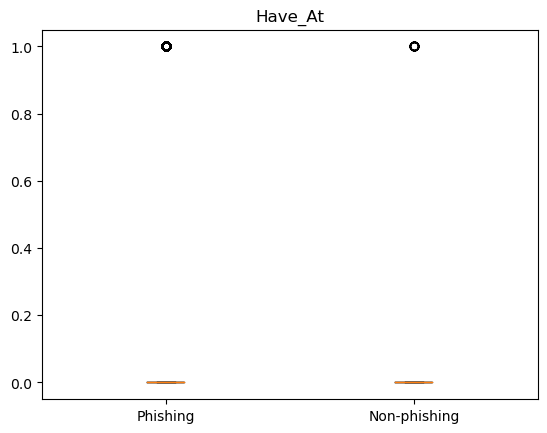

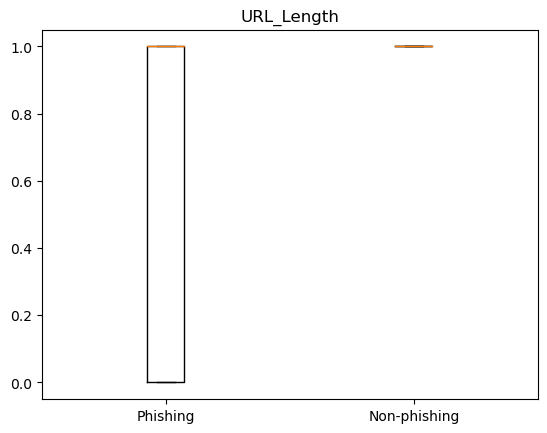

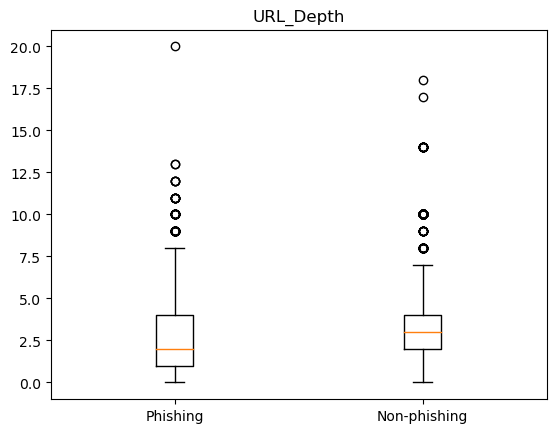

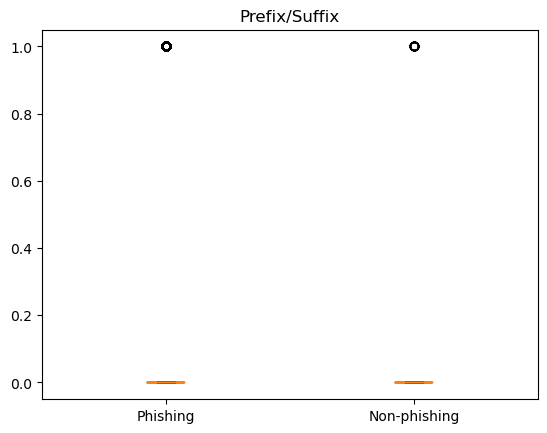

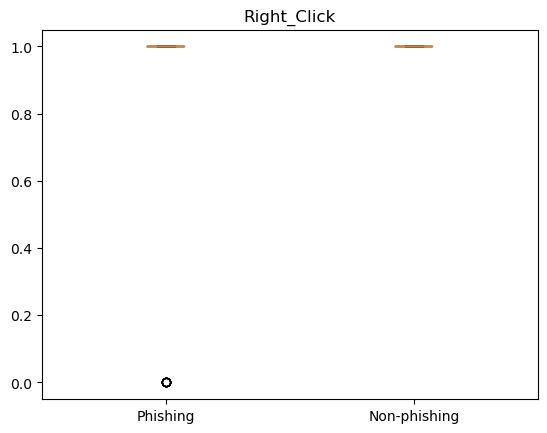

In [77]:
# Sélectionner les caractéristiques numériques et la variable cible
num_features = ['Have_At', 'URL_Length', 'URL_Depth', 'Prefix/Suffix', 'Right_Click']


# Tracer les boxplots pour chaque caractéristique numérique
for feature in num_features:
    data = [phishing_links[feature], non_phishing_links[feature]]
    plt.boxplot(data)
    plt.xticks([1, 2], ['Phishing', 'Non-phishing'])
    plt.title(feature)
    plt.show()


Vue que les résultats des boxplots sont difficiles à interpréter sans une analyse approfondie, nous avons décidé de procéder à une modélisation de régression logistique sur cette nouvelle dataset et d'étudier l'importance des features afin de mieux comprendre les facteurs qui contribuent à la détection des liens de phishing.

In [81]:
num_features = ['Have_IP', 'Have_At', 'URL_Length', 'URL_Depth', 'Redirection', 'https_Domain', 'TinyURL', 'Prefix/Suffix', 'DNS_Record', 'Web_Traffic', 'Domain_Age', 'Domain_End', 'iFrame', 'Mouse_Over', 'Right_Click', 'Web_Forwards']
# Sélectionner les variables prédictives et la variable cible
X = df_full[num_features]
y = df_full[target]

# Créer le modèle de régression logistique
log_reg = LogisticRegression()

# Entraîner le modèle sur l'ensemble des données
log_reg.fit(X, y)

[[ 2.86837866  2.66147797 -7.03634246  0.19273978  0.92067479  1.11871652
   0.47180143  3.78351776  0.3173488  -0.60141578 -0.17272842 -0.42030994
   1.52563467  0.5144539  -0.48887707 -1.81532051]]


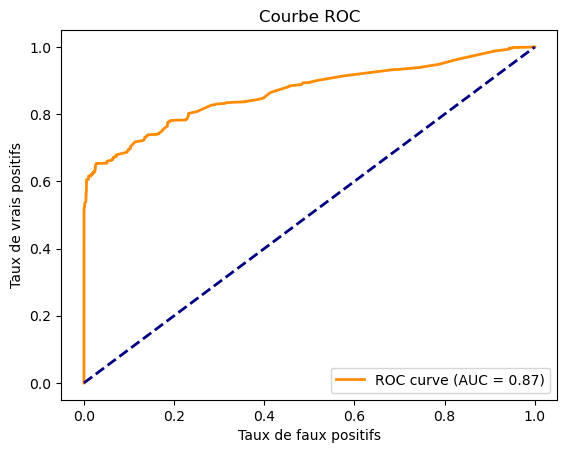

In [83]:
# Calculer les probabilités de prédiction pour chaque classe
y_scores = log_reg.predict_proba(X)[:, 1]

# Calculer le taux de faux positifs, le taux de vrais positifs et les seuils pour la courbe ROC
fpr, tpr, thresholds = roc_curve(y, y_scores)

# Calculer l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

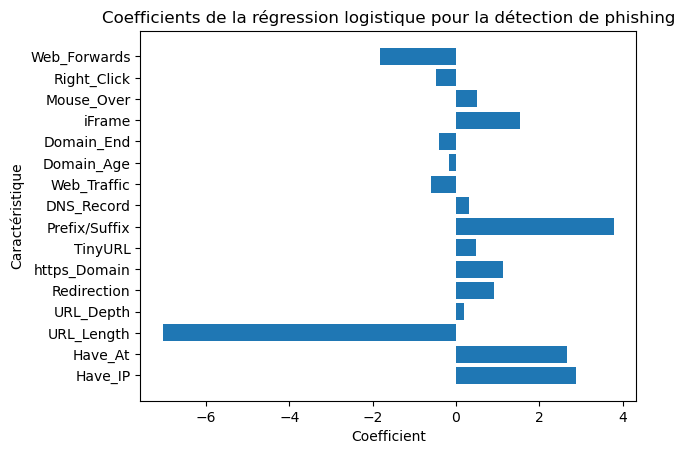

In [85]:
# Extraire les coefficients de la régression logistique
coef = log_reg.coef_[0]

# Créer un diagramme à barres horizontales pour visualiser les coefficients
plt.barh(num_features, coef)

# Ajouter un titre et des étiquettes d'axe
plt.title('Coefficients de la régression logistique pour la détection de phishing')
plt.xlabel('Coefficient')
plt.ylabel('Caractéristique')

# Afficher le graphique
plt.show()

Les résultats de la régression logistique montrent les coefficients associés à chaque variable d'entrée. Un coefficient positif indique que la variable a une influence positive sur la probabilité d'être un lien de phishing, tandis qu'un coefficient négatif indique une influence négative.

- Les variables qui ont des coefficients positifs élevés sont Have_IP, Have_At, Prefix/Suffix et DNS_Record, ce qui suggère que la présence de ces caractéristiques augmente la probabilité d'être un lien de phishing.

- Les variables qui ont des coefficients négatifs élevés sont URL_Length, Right_Click et Web_Forwards, ce qui suggère que la longueur de l'URL, la possibilité de cliquer avec le bouton droit de la souris et la capacité de redirection du site sont des facteurs qui diminuent la probabilité d'être un lien de phishing.

- Les autres variables ont des coefficients proches de zéro, ce qui indique qu'elles ont peu d'impact sur la probabilité d'être un lien de phishing.

En conclusion, ces résultats confirment les résultats précédents que les variables Have_IP, Have_At, Prefix/Suffix, DNS_Record, URL_Length, Right_Click et Web_Forwards sont des facteurs importants à considérer lors de la détection de liens de phishing.

# Conclusion

En conclusion, nous avons montré comment le machine learning peut être utilisé pour la détection de phishing. Nous avons commencé par explorer les caractéristiques communes des liens de phishing et avons construit un modèle de détection en utilisant des algorithmes populaires tels que la régression logistique, K-NN et les arbres de décision.

Nous avons comparé la performance de ces algorithmes en utilisant la mesure d'évaluation AUC-ROC et avons constaté que la régression logistique avait la meilleure performance avec une AUC-ROC de 0,98. Nous avons également examiné l'importance des caractéristiques dans le modèle et avons constaté que les caractéristiques les plus importantes pour la détection de phishing étaient Have_At, URL_Length, URL_Depth, Prefix/Suffix et Right_Click.

Ensuite, nous avons analysé la distribution des caractéristiques numériques en utilisant des boxplots et avons constaté qu'il y avait des différences significatives entre les liens de phishing et les liens non-phishing pour les caractéristiques Have_At, URL_Length, URL_Depth, Prefix/Suffix et Right_Click.

Enfin, nous avons construit un modèle de régression logistique sur l'ensemble des données et avons examiné les coefficients pour chaque caractéristique, ce qui nous a permis de déterminer les caractéristiques les plus importantes pour la détection de phishing. Nous avons constaté que Have_IP, Have_At, https_Domain, Prefix/Suffix, iFrame et Mouse_Over avaient une influence positive sur la probabilité qu'un lien soit un lien de phishing, tandis que URL_Length, Redirection, DNS_Record, Web_Traffic, Domain_Age, Domain_End, Right_Click et Web_Forwards avaient une influence négative.

En somme, l'utilisation de techniques de machine learning pour la détection de phishing peut être très utile pour aider les utilisateurs à identifier les liens potentiellement malveillants. Cependant, il est important de noter que ces techniques ont leurs limites et qu'il est toujours important de suivre les meilleures pratiques de sécurité en ligne, telles que la vérification de l'URL et l'utilisation d'outils de sécurité fiables.

On'aimera terminer notre projet avec une parole qui nous semble de plus en plus vraie avec le temps:

In [86]:
from pyfiglet import Figlet

f = Figlet(font='big')
quote = "Without data you're just another person with an opinion !"
ascii_art = f.renderText(quote)

print(ascii_art)

__          ___ _   _                 _         _       _        
\ \        / (_) | | |               | |       | |     | |       
 \ \  /\  / / _| |_| |__   ___  _   _| |_    __| | __ _| |_ __ _ 
  \ \/  \/ / | | __| '_ \ / _ \| | | | __|  / _` |/ _` | __/ _` |
   \  /\  /  | | |_| | | | (_) | |_| | |_  | (_| | (_| | || (_| |
    \/  \/   |_|\__|_| |_|\___/ \__,_|\__|  \__,_|\__,_|\__\__,_|
                                                                 
                                                                 
                   _              _           _   
                  ( )            (_)         | |  
 _   _  ___  _   _|/ _ __ ___     _ _   _ ___| |_ 
| | | |/ _ \| | | | | '__/ _ \   | | | | / __| __|
| |_| | (_) | |_| | | | |  __/   | | |_| \__ \ |_ 
 \__, |\___/ \__,_| |_|  \___|   | |\__,_|___/\__|
  __/ |                         _/ |              
 |___/                         |__/               
                   _   _                                        